In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
import sys
plt.style.use("~/evanstyle.mplstyle")

sys.path.append("../CombinedData/")
import Dataset

In [2]:
topdir = "../../data/Run7/"
datasets = ["cosmics-endofrun/", "ds01/","ds02/","ds03/", "ds04/","ds05/","ds06/","ds07/",\
        "ds08/","ds09/","ds10/","ds11/","filling/", "room-temp-dark-noise/"]

ds_single = "ds11/"
config = "../configs/run7_config.yaml"

In [3]:
ds = Dataset.Dataset(topdir+ds_single, config)

Extracting timing info from PMT files...
Binning in time to get rate


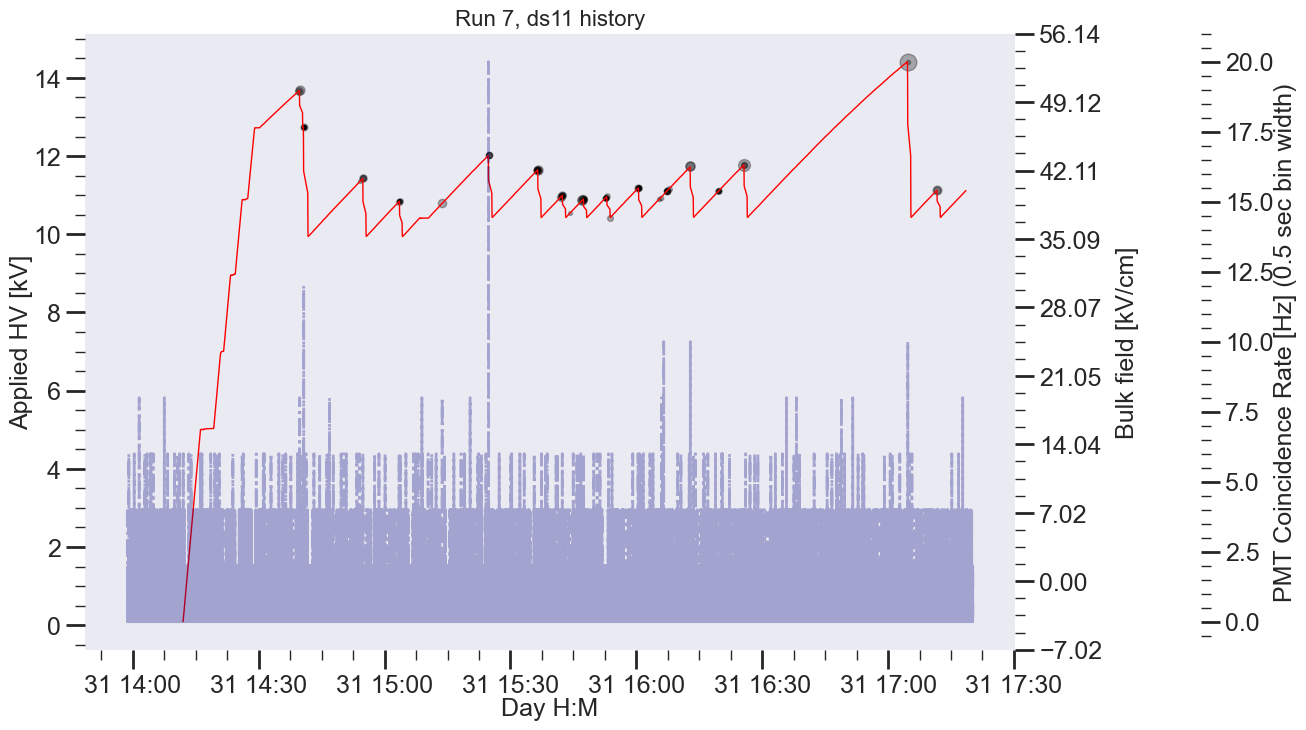

In [18]:
#pmt rate plot settings
binwidth = 0.5 #seconds
ds.identify_ramps()
pmt_times, rates = ds.load_rate_curves_into_ramps(binwidth)

#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
fig, ax = plt.subplots()

for ramp in ds.ramps:
    ax.plot(ramp["t"], ramp["v_mon"], 'r', linewidth=1)
    
for ramp in ds.flat_tops:
    ax.plot(ramp["t"], ramp["v_mon"], 'k')
    
    

#get any charge events above 2 mV
amp_th = 2
events = [] #{"time": datetime, "amp": mV, "hv": kV con}
for f in ds.ad2_files:
    df, date = pickle.load(open(f, "rb")) #opens the pandas dataframe object in the pickle file
    for evidx, row in df.iterrows():
        ch1 = row["Data"][0]
        dT = row["dT"]
        if(np.max(ch1) > amp_th):
            evt_time = datetime.datetime.fromtimestamp(row["Seconds"])
            amp = np.max(ch1)
            kv = ds.get_hv_at_time(row["Seconds"])
            events.append({"time":evt_time, "amp":amp, "hv":kv})

for ev in events:
    ax.scatter(ev["time"], ev["hv"], s=15*ev["amp"], color='k', alpha=0.3)


gap = 0.285 #cm
axe = ax.twinx()
axe.set_yticks(np.array(ax.get_yticks())/gap)
axe.set_ylabel('Bulk field [kV/cm]', labelpad=10)
axe.grid(False)


axp = ax.twinx()
axp.plot(pmt_times, rates, '-.', linewidth=2, alpha=0.3,color='navy')
axp.spines.right.set_position(("axes", 1.2))
axp.set_ylabel("PMT Coincidence Rate [Hz] ({:.1f} sec bin width)".format(binwidth))

ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Day H:M")
ax.set_title("Run 7, ds11 history")
ax.grid(False)
axp.grid(False)
#ax.set_xlim([datetime.datetime(2023, 7, 31, 16, 0, 0), datetime.datetime(2023, 7, 31, 16, 1, 30)])
#ax.set_ylim([10.5, 11.5])
plt.show()